In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from SparkDC import FancyPlot
from SparkDC import ConditioningData
from SparkDC import StatusData
from SparkDC import RGAData
from SparkDC import FieldEmissionData

# SparkDC
## A library for reading and for plotting data generated in the SparkDC experiment at FREIA laboratory

### Introduction

Conditioning of a metal surface in a high-voltage system is the progressive development of resistance to vacuum arcing over the operational life of the system. This is relevant for accelerator cavities where high level of performance is only achievable after long conditioning period. Beyond the accelerator research field, this is an important topic for any technology where breakdowns can cause device failure, either by directly disrupting device operation or by causing cumulative hardware damage.

We conditioning electrodes using high voltage pulses at cryogenic temperature. During the conditioning process, we have vacuum arcing (or breakdowns) between the electrodes. Let's generate a typical conditioning plot. In this example, we will use the data from a pair of Nb electrodes.

### Conditioning Data

First load the data, then make the plot.

In [2]:
cond_folder = './Example Data' # the folder containing the conditioning data for all electrodes
electrode = '066_RFQ_Nb_rm1' # the name of our current electrode
runs = np.arange(1, 11) # we have split the conditioning into multiple conditioning runs
cond_data = ConditioningData.read_runs(cond_folder, electrode, runs)

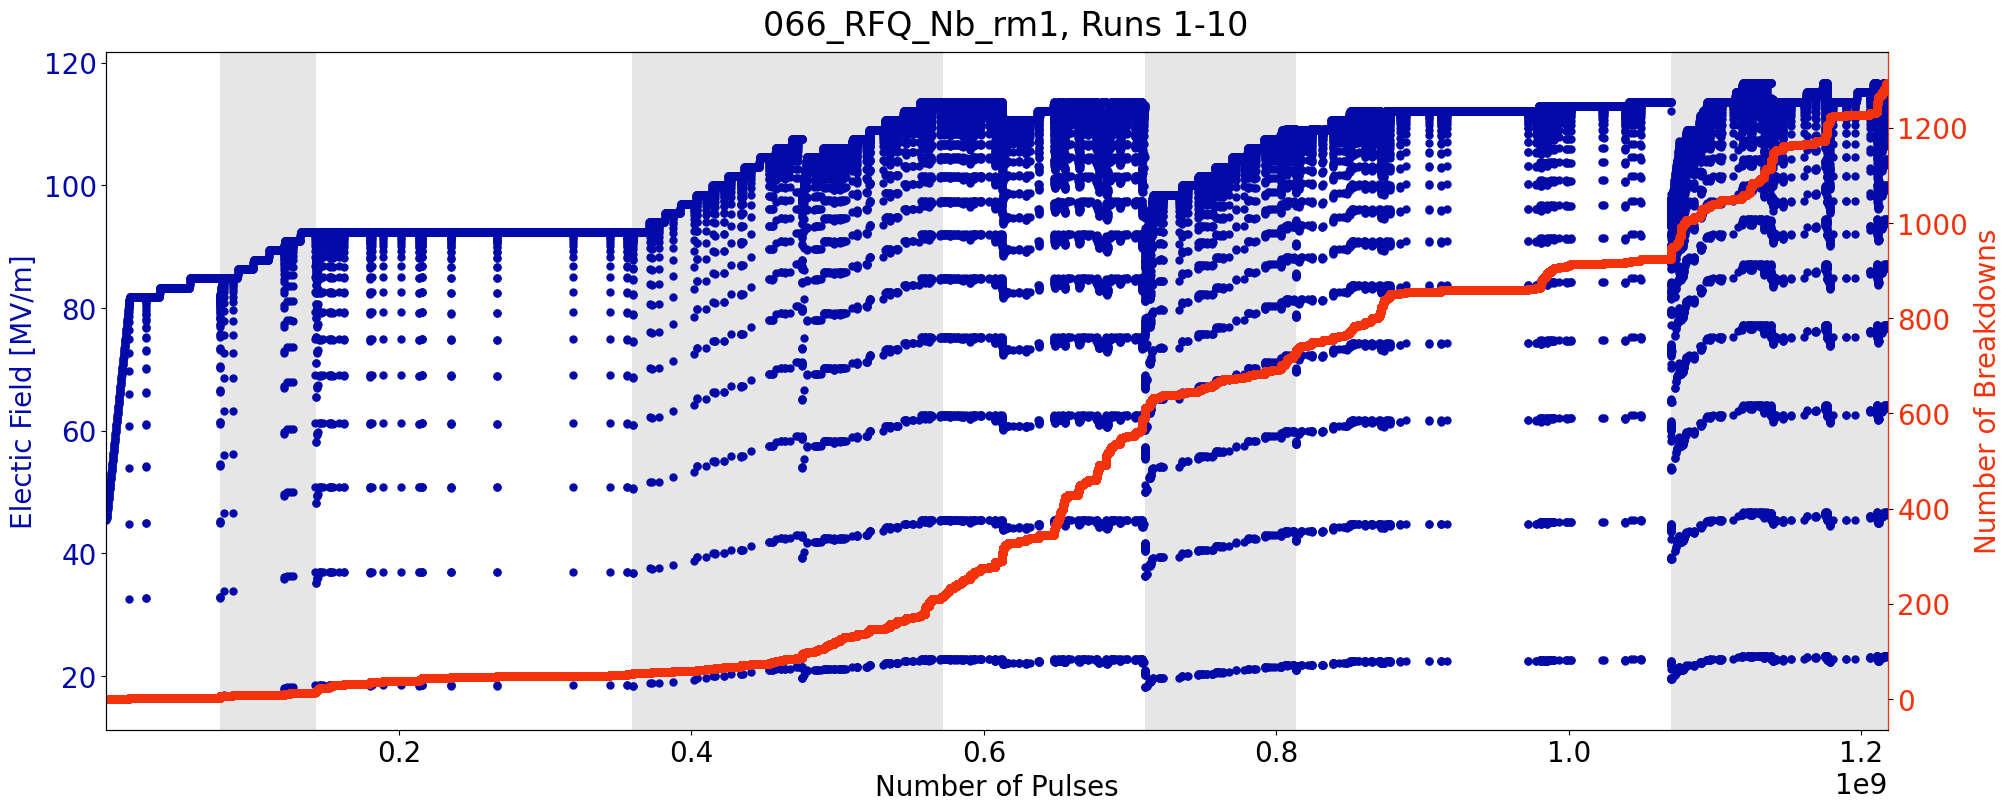

In [3]:
cplot = cond_data.plot_standard(stripe=True, fontsize = 20)
plt.show()

During conditioning, the electric field increases from around 40 to around 110 MV/m and we had around 1300 breakdowns. The stripes indicate the different conditioning runs. We can also add a third axis to this plot which shows the breakdown rate.

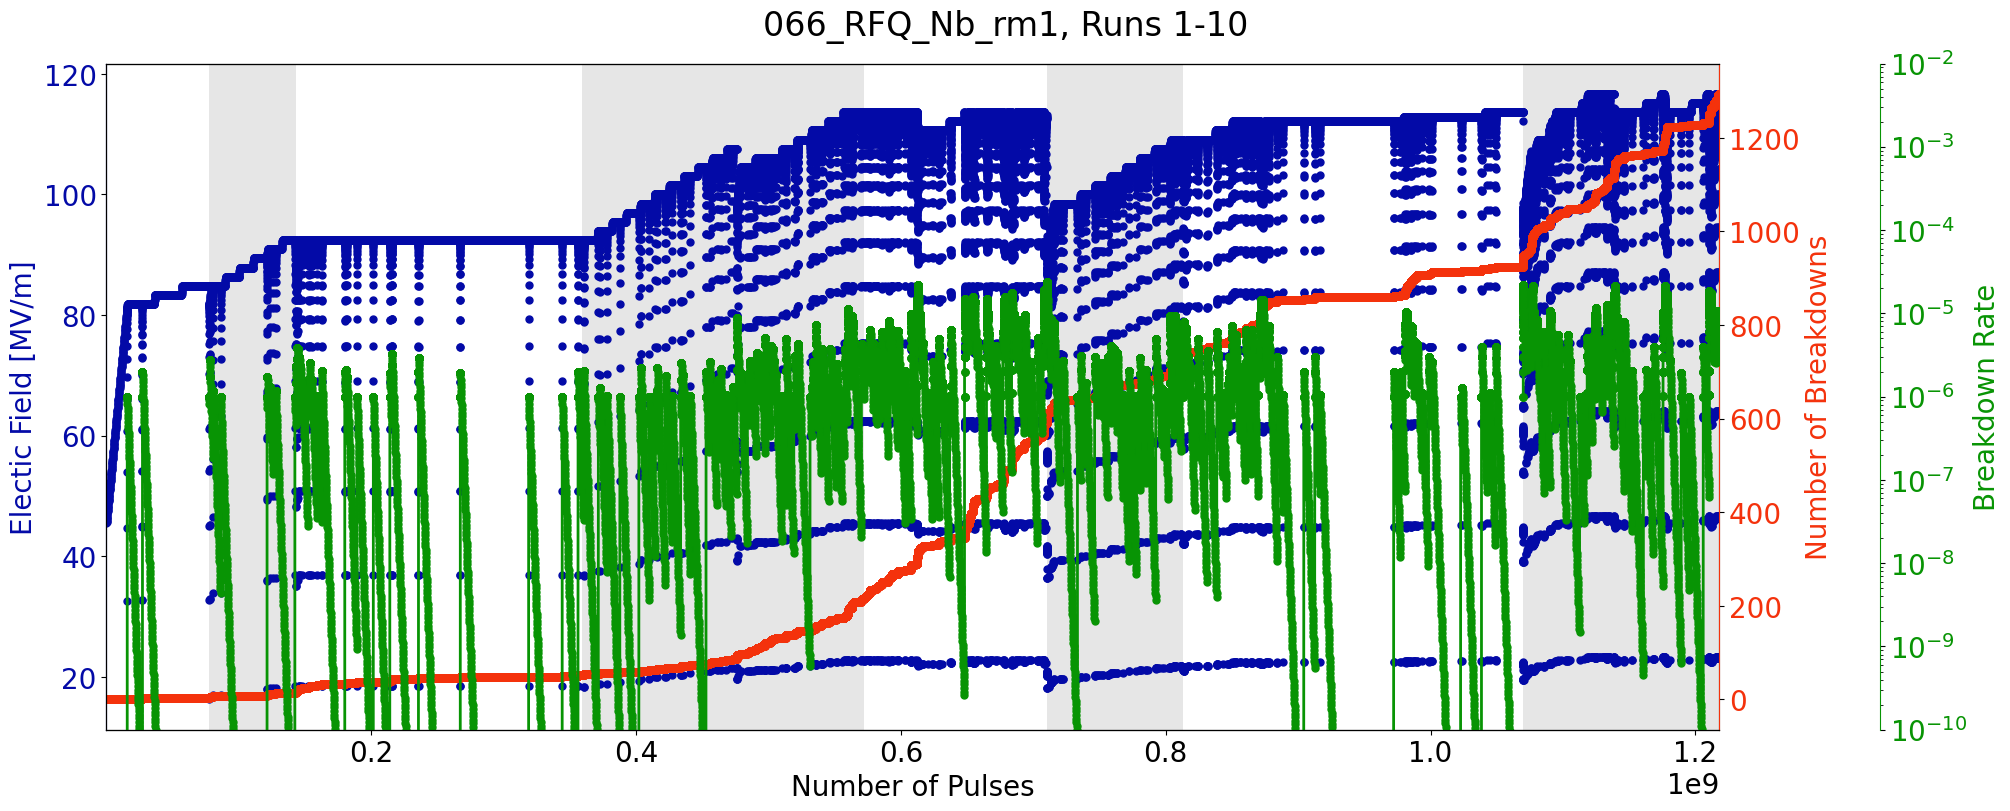

In [4]:
cplot = cond_data.plot_standard(stripe=True, plot_third_axis = True, fontsize = 20)
cplot.set_axis_ylim(2, [1E-10, 1E-2]) # set the ylimit for the third axis
plt.show()

### Temperature Data

The experiments are run at cryogenic temperatures. Between conditioning runs, we also do field emission measurements at different temperatures. Now I am going to demonstrate how to read temperature data.

The temperature data files are all stored in a folder. Typically it is a lot of work to identify the correct file to use for a specific measurement of interest. But, using the new library, this can be done in a single line. Let's read the data from 1st of November 2023, from 12:00:00 to 16:30:00.

In [5]:
status_folder = './Example Data/CryoDC/'
range = ['20231101-120000', '20231101-163000']
status_data = StatusData.read_from_folder_between_datetimes(status_folder, range)

And plot it. We are going to plot first the temperatures read by two of the channels of our temperature controller, corresponding to cathode and anode temperature

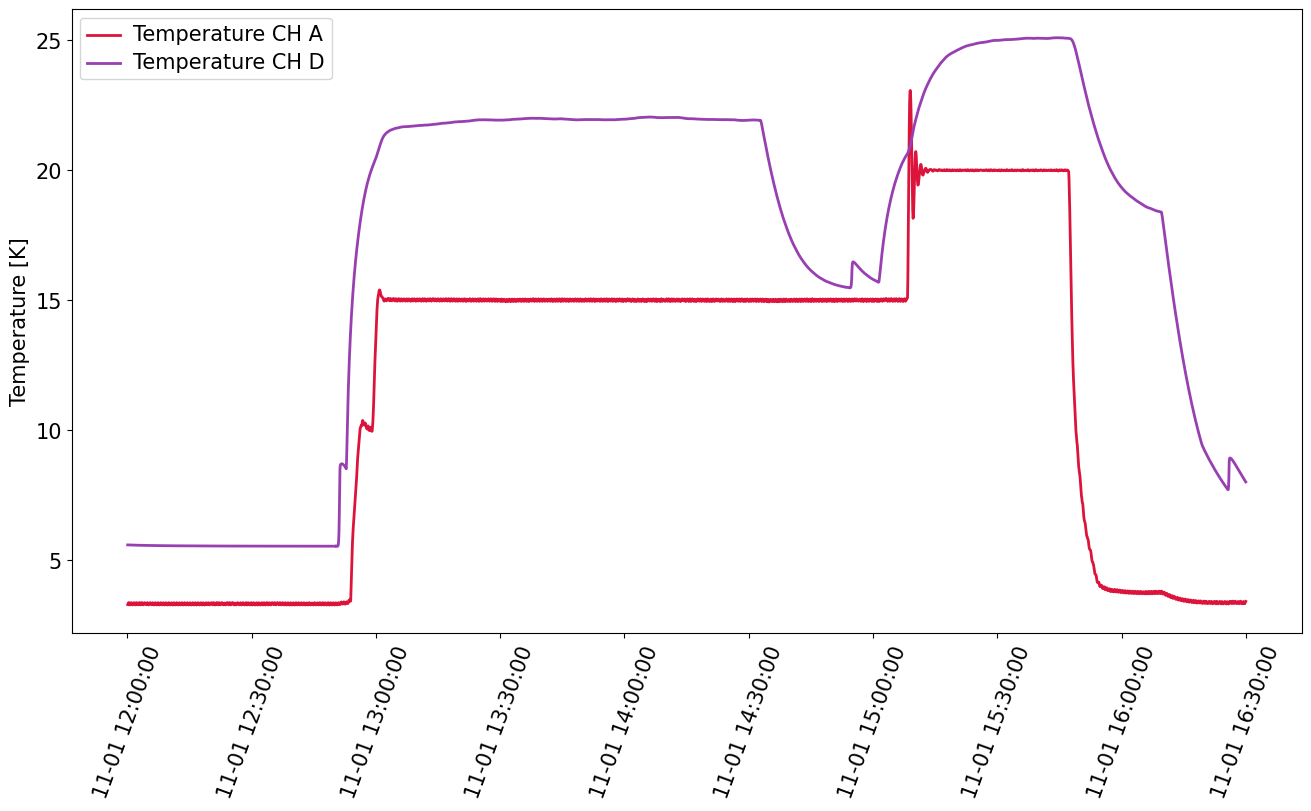

In [6]:
splot = status_data.plot(['temp_A', 'temp_D'])
splot.legend()
splot.set_ylabels('Temperature [K]')
splot.set_fontsize(15)
plt.show()

We can also add a new axis, with some other data. For example, I will add the power of the heater that is used to increase the temperature from 4K to 15K on the cathode.

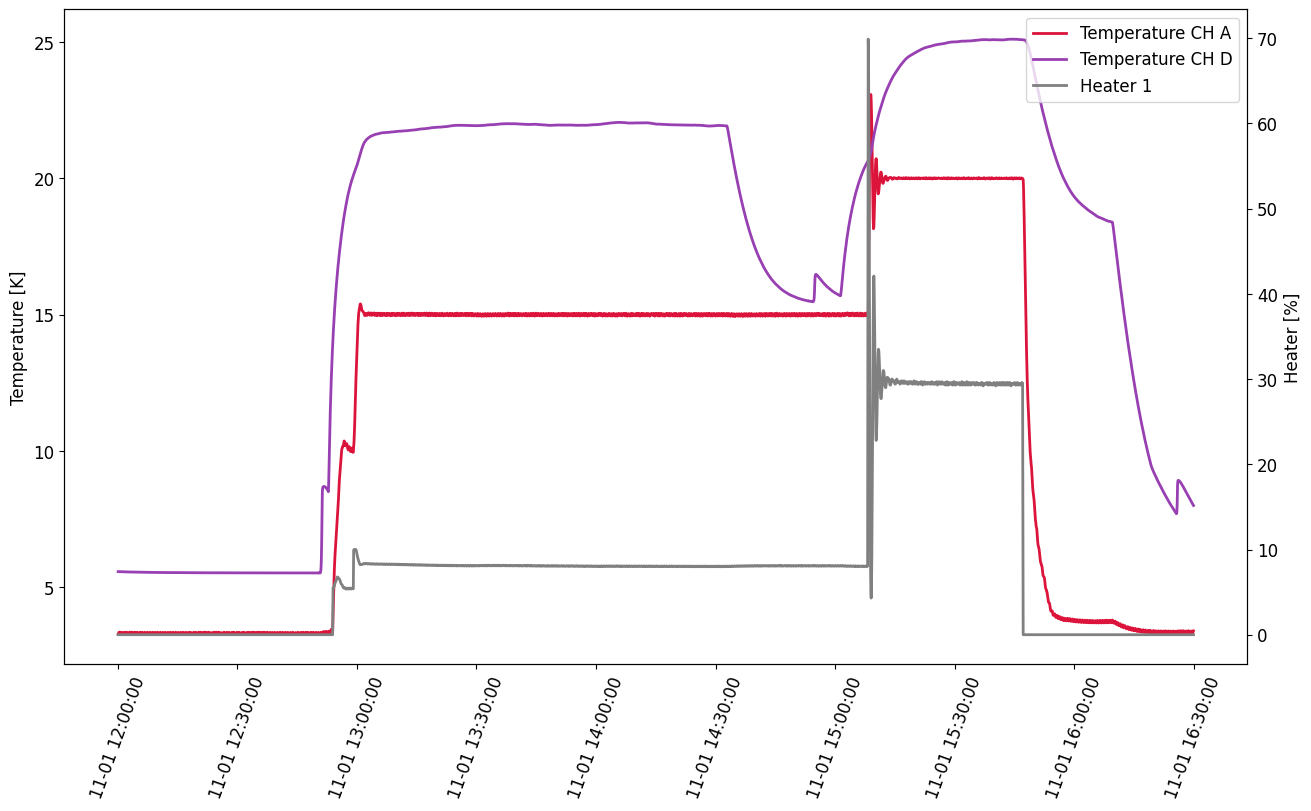

In [7]:
splot = status_data.plot([['temp_A', 'temp_D'], ['heater_1']])
splot.legend()
splot.set_ylabels('Temperature [K]', 'Heater [%]')
plt.show()

While heating up, we also measured the current and we looked for desorbed gases from the electrode surface using an RGA. 

### Residual Gas Analyzer Data

First load the RGA file

In [8]:
rga_file = './Example Data/rga_231101.csv'
rga_data = RGAData.read_from_file(rga_file)
rga_data.remove_data_datetime_range(range) #remove data outside the selected range

And make the plot for the 2 amu (hydrogen) and 18 amu (water)

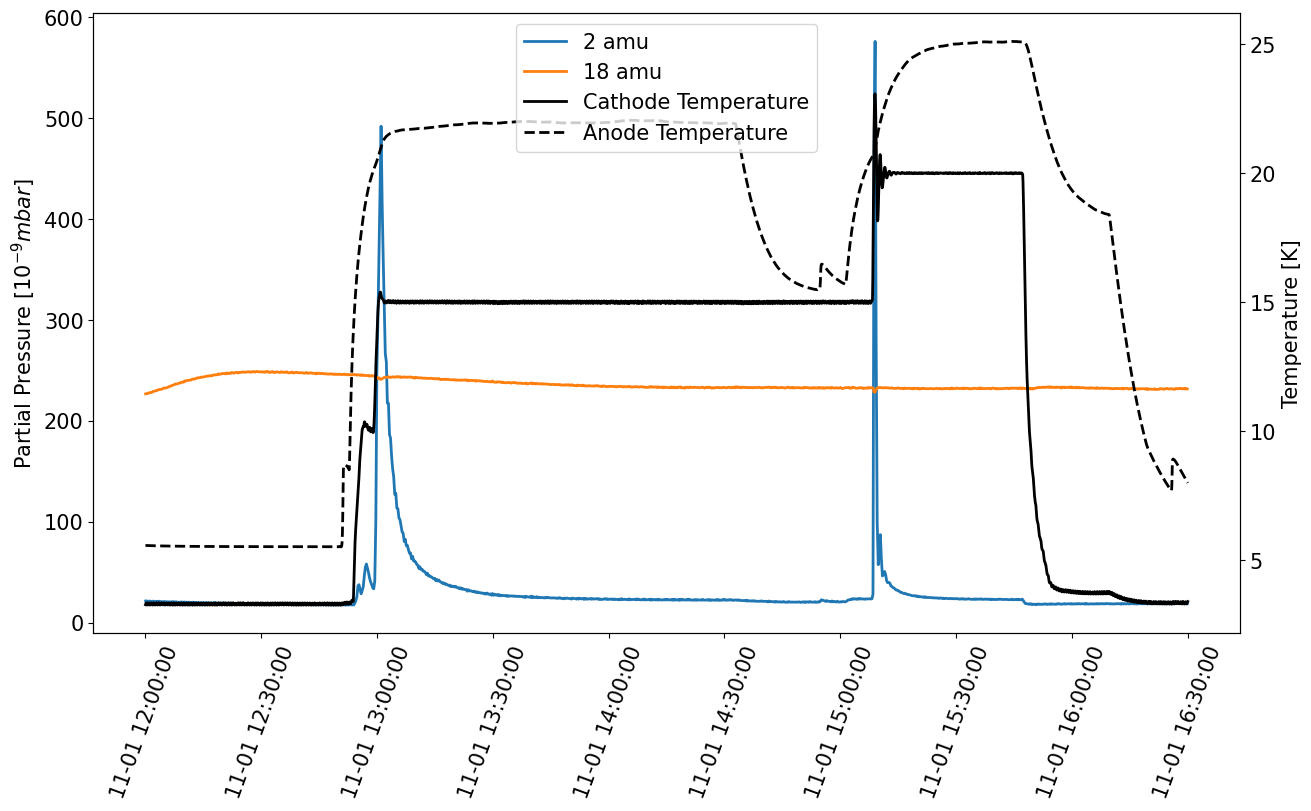

In [21]:
# Make empty plot with 2 axis
fplot = FancyPlot(n_ax = 2, style_dict = None, fontsize = 15, fontweight = 'normal') # create new fancy plot with 2 axes, which does not use any implicitely defined colors for plot

# plot channel A and D on the second axis of the fplot, with the specified labels, colors and linestyle
fplot = status_data.plot(['temp_A', 'temp_D'], fplot = fplot, ax_id = 1, \
                         labels = ['Cathode Temperature', 'Anode Temperature'], \
                         color = 'k', linestyle = ['solid', 'dashed'], 
                        )
fplot = rga_data.plot_masses([2, 18], fplot = fplot, ax_id = 0, scaling_y = 1E9)
fplot.legend(loc = 'upper center')
fplot.set_ylabels(r'Partial Pressure [$10^{-9} mbar$]', 'Temperature [K]')
#fplot.fig

We see that the partial pressure of water is constant while the hydrogen increases every time we heat up the system

### Field Emission

We also measured the field emission current when a constant electric field of aroud 70MV/m is applied between the electrodes. How does the current evolve?

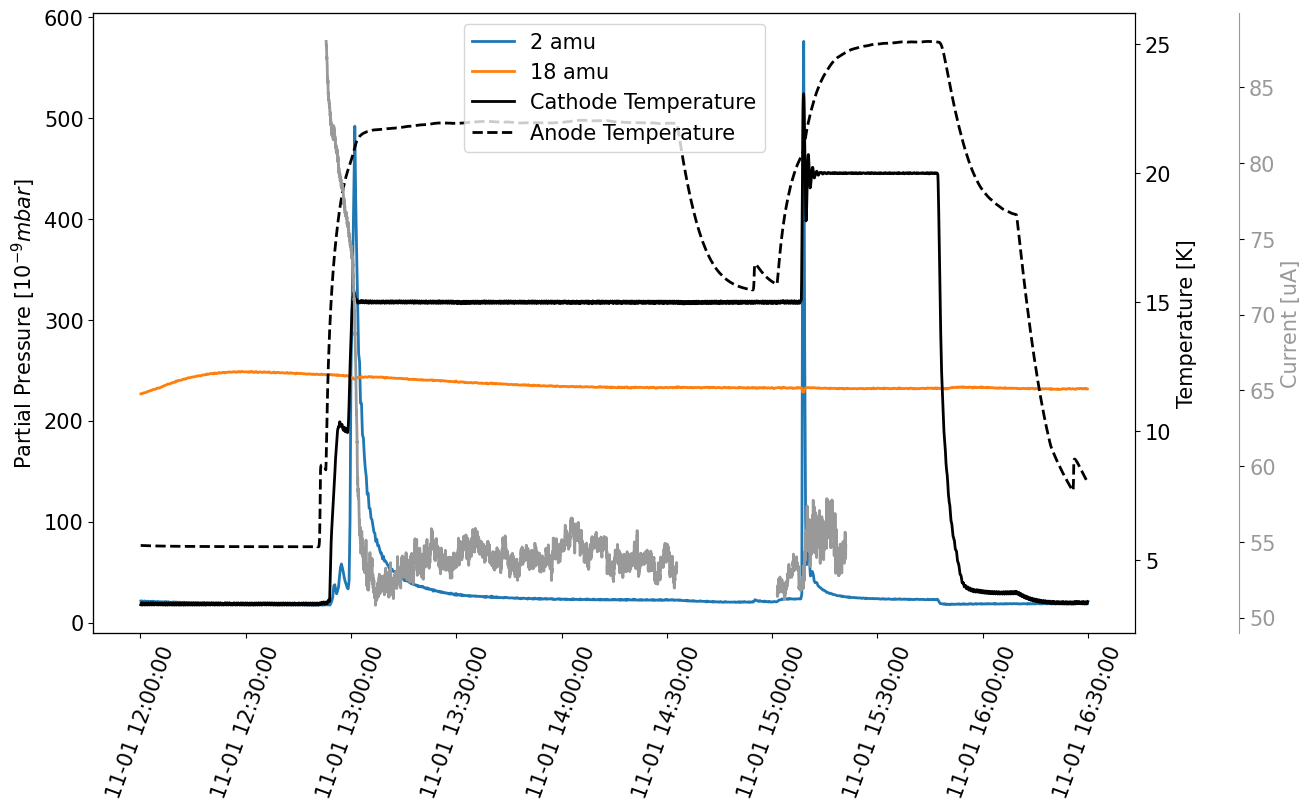

In [22]:
FE_folder = 'Example Data/FieldEmission/'
files_FE_constant = [
    FE_folder+'heinz_ramp_20231101-125248.dat',
    FE_folder+'heinz_ramp_20231101-150122.dat'
]

fe_data = FieldEmissionData.read_from_files(files_FE_constant, skiprows = 6)

# plot the data
fplot.add_axis() # add a new axis
fplot.set_axis_ylabel(2, 'Current [uA]') # set the label for the third axis
fe_data.plot('current', color = '0.6', fplot = fplot, ax_id = 2, scaling_y = 1E3)
fplot.set_spine_color(2, '0.6') #change the color of third axis
fplot.fig

The current decreases during field emission. We also made measurements in which the the field varies from 0 to 80 MV/m before and after heating the electrodes. 

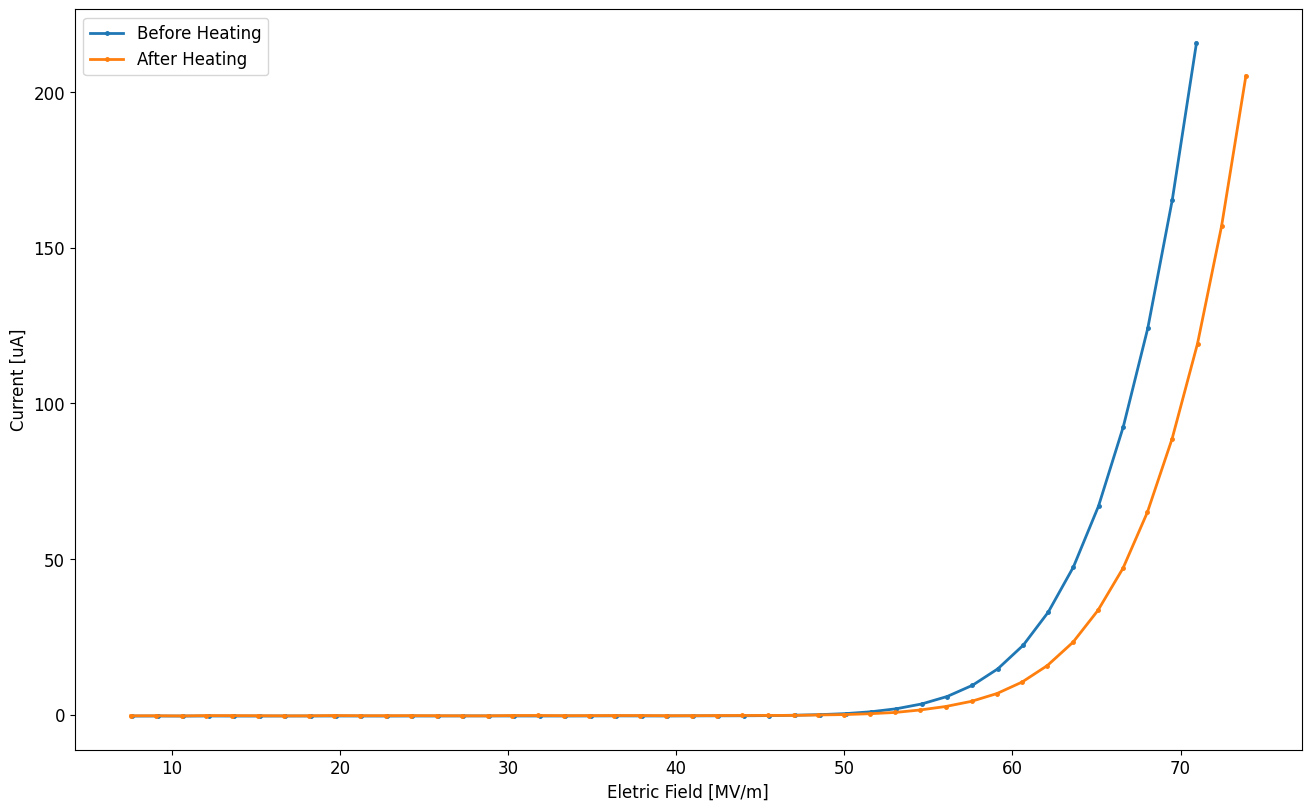

In [15]:
file_FE_1 = FE_folder + 'heinz_ramp_20231101-112443.dat'
file_FE_2 = FE_folder + 'heinz_ramp_20231101-172458.dat'

FE_data_1 = FieldEmissionData.read_from_files(file_FE_1, current_limiting_resistor = 100E3, gap = 66,  skiprows = 6)
FE_data_2 = FieldEmissionData.read_from_files(file_FE_2, current_limiting_resistor = 100E3, gap = 66, skiprows = 6)

ivplot = FE_data_1.plot_IV(x_key = 'true_field', marker = '.', label = 'Before Heating')
FE_data_2.plot_IV(x_key = 'true_field', fplot = ivplot, marker = '.', label = 'After Heating')
ivplot.legend()
plt.show()

Usually, this type of plots are made with the 1/(Electric Field) on the x axis and the current in log scale

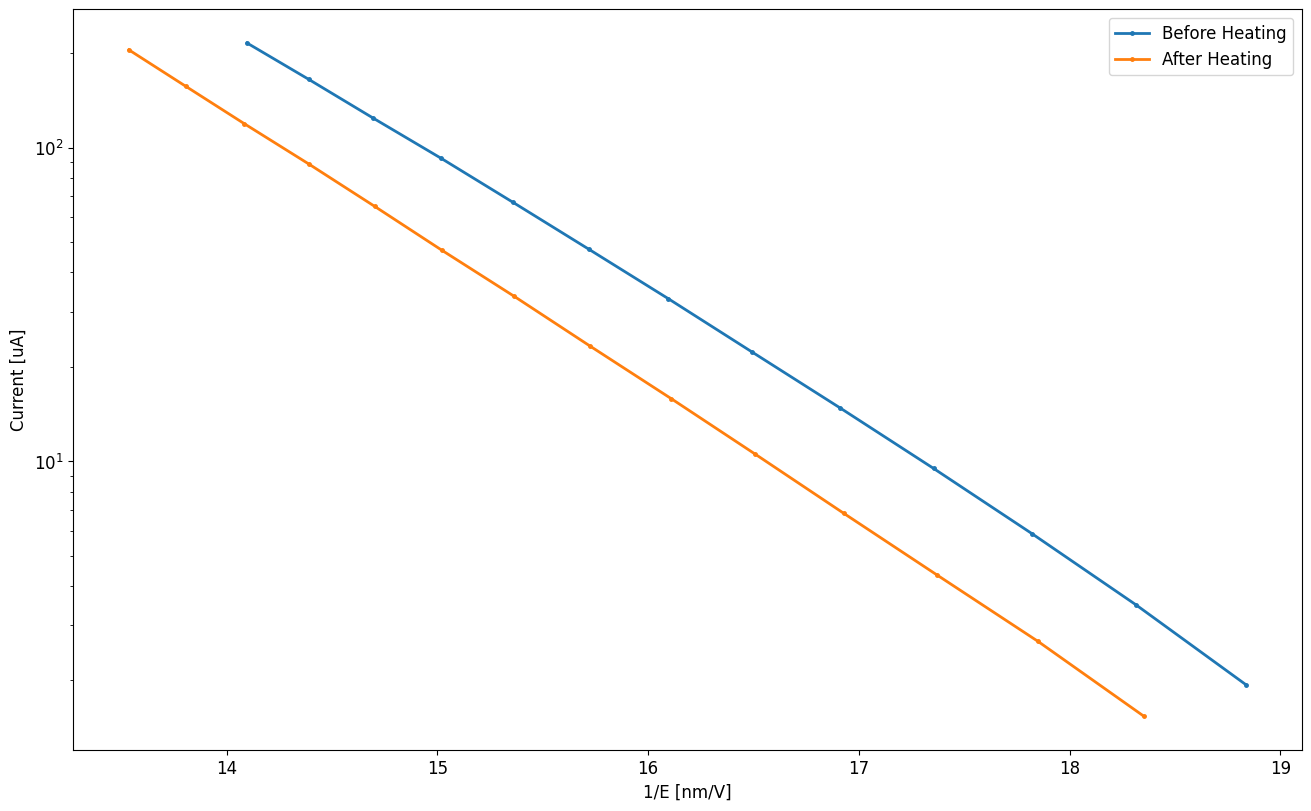

In [14]:
ivplot = FE_data_1.plot_IV(x_key = 'true_field', FN_plot = True, marker = '.', label = 'Before Heating')
FE_data_2.plot_IV(x_key = 'true_field', FN_plot = True, fplot = ivplot, marker = '.', label = 'After Heating')
ivplot.legend()
plt.show()